# WALRUS in eWaterCycle

This notebook is to showcase/test the containerized model.

Note: the [WALRUS BMI](https://raw.githubusercontent.com/eWaterCycle/grpc4bmi-examples/master/walrus/walrus-bmi.r) 
is barely implemented and relies on "faking it"; `.update()` actually doesn't update the model: it ran the entire simulation already on `.initialize()`.

*This notebook is only to demonstrate communication between eWaterCycle and an R-based model inside a container.*

We import the WALRUS model:

In [ ]:
from ewatercycle_walrus.model import WALRUS
from ewatercycle_walrus.forcing import WALRUSForcing

import ewatercycle
from pathlib import Path
import numpy as np

To be able to initialize the model, we need forcing data.

This can be generated from ERA5, or loaded if you have pre-generated this data.

In [2]:
shape = Path(ewatercycle.__file__).parent / "testing/data/Rhine/Rhine.shp"

# forcing = WALRUSForcing.generate(
#     dataset="ERA5",
#     start_time="2000-01-01T00:00:00Z",
#     end_time="2000-12-31T00:00:00Z",
#     shape=shape.absolute(),
# )

forcing = WALRUSForcing.load('/home/bart/esmvaltool_output/ewcreps4nriqgh_20241121_092901/work/diagnostic/script')

In [3]:
forcing.to_xarray()

<xarray.Dataset> Size: 9kB
Dimensions:        (time: 366, date: 366)
Coordinates:
    time           (date) datetime64[ns] 3kB 2000-01-01T12:00:00 ... 2000-12-...
Dimensions without coordinates: date
Data variables:
    precipitation  (time) float64 3kB 2.55 0.2932 0.1681 ... 2.524 2.289 0.4903
    evspsblpot     (time) float64 3kB 0.612 0.5287 0.4964 ... 0.5296 0.4943
Attributes:
    title:    WALRUS forcing data
    history:  Created by ewatercycle_walrus.forcing.WALRUSForcing.to_xarray()

Now we can start the model. The `WALRUS` class uses a container hosted on the Github container registry.

In [4]:
model = WALRUS(forcing=forcing) 
cfg_file, _ = model.setup()

With the config file generated by eWaterCycle, we can intialize the model:

In [5]:
model.initialize(cfg_file)

We can directly ask the BMI what the name is of the component:

In [6]:
model.bmi.get_component_name()

'WALRUS'

The model can be updated to the next time step with `.update()`:

In [7]:
model.update()

WALRUS has a few output variable names:

In [8]:
model.output_var_names

('ETact', 'Q', 'fGS', 'fQS', 'dV', 'dVeq', 'dG', 'hQ', 'hS', 'w')

We can request the discarge value at the current time step:

In [9]:
model.get_value("Q")

array([0])

To test the model, we'll make a hydrograph:

In [10]:
discharges = []
for _ in range(365):
    discharges.append(model.get_value("Q"))
    model.update()

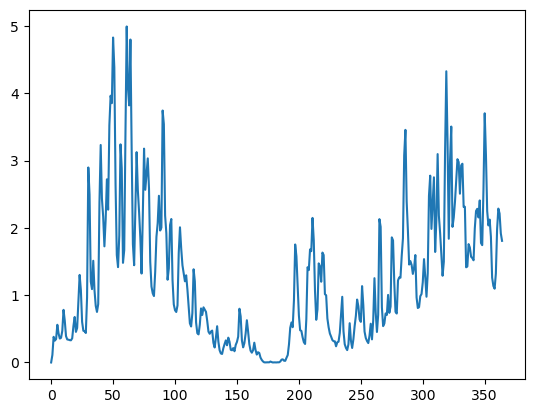

In [11]:
import matplotlib.pyplot as plt
plt.plot(np.array(discharges))

To make sure that the container running the model is nicely shut down and doesn't keep running in the background (taking up resources) we need to 'finalize' it.

In [12]:
model.finalize()